# destripe processsing in spikeinterface

Author : Samuel Garcia

Olivier Winter has develop for IBL a standard pre-processing chain in the `ibllib` to clean the traces before spike sorting.
See [this](https://github.com/int-brain-lab/ibllib/blob/master/ibllib/dsp/fourier.py)

This procesdure is called **"destripe"**.
This procedure remove artefact that are present on all channels (common noise)


The main idea is to have this:
  1. filter
  2. align sample (phase shift
  3. remove common noise
  4. apply spatial filter and bad channel interpolation
 
Except step 4., all other steps are available in spikeinterface

`spikeinterface.toolkit.preprocessing` propose some class and function to build what we call a lazy chain of processing.

Here an example with 4 files nicely given by Oliver Winter to illustarte the spikeinterface implementation of this **destripe** procedure.





In [42]:
# %matplotlib widget
%matplotlib inline

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from pathlib import Path

import time

import numpy as np
import matplotlib.pyplot as plt


import spikeinterface.full as si

In [21]:
base_folder = Path('/media/samuel/dataspikesorting/DataSpikeSorting/olivier_destripe/')

folder1 = base_folder / '4c04120d-523a-4795-ba8f-49dbb8d9f63a'
folder2 = base_folder / '68f06c5f-8566-4a4f-a4b1-ab8398724913'
folder3 = base_folder / '8413c5c6-b42b-4ec6-b751-881a54413628'
folder4 = base_folder / 'f74a6b9a-b8a5-4c80-9c30-7dd4cdbb48c0'
data_folders = [folder1, folder2, folder3, folder4]

### Build the prprocessing chain

In spike interface we have:
  * `bandpass_filter()`
  * `common_reference()`: this remove common noise (global or local) by substraction of median (or average)
  * `phase_shift()`: this compensate the ADC shift across channel by applying a reverse in FFT transform.

That can be combined to get ore or less the same result than the **"destripe"**.

Here we will compare 2 preprocessing:
  1. filter > cmr
  2. filter > phase_shift > cmr

The step 4. (kfilter) is not implemented yet but this should be done soon.


In [38]:
# lets have a function that build the chain and plot intermediate results

def preprocess_steps(rec, time_range=None, clim=(-80, 80), figsize=(15, 10)):
    
    # chain 1. : filter + cmr
    rec_filtered = si.bandpass_filter(rec, freq_min=300., freq_max=6000., dtype='float32')
    rec_cmr = si.common_reference(rec_filtered, reference='global', operator='median')
    
    # chain 2.. : filter + phase_shift + cmr
    rec_pshift = si.phase_shift(rec_filtered)
    rec_cmr2 = si.common_reference(rec_pshift, reference='global', operator='median')
    
    
    # rec
    fig, axs = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=figsize)
    
    ax = axs[0]
    ax.set_title('raw')
    si.plot_timeseries(rec, ax=ax,  with_colorbar=False) # clim=clim,
    
    # filter
    
    ax = axs[1]
    ax.set_title('filtered')
    si.plot_timeseries(rec_filtered, ax=axs[1], clim=clim, with_colorbar=False)
    
    # filter + cmr
    
    # rec_preprocessed
    ax = axs[2]
    ax.set_title('filtered + cmr')
    si.plot_timeseries(rec_cmr, ax=axs[2], clim=clim, with_colorbar=False)
    
    # filter + phase_shift
    
    ax = axs[3]
    ax.set_title('filtered + phase_shift')
    si.plot_timeseries(rec_pshift, ax=ax, clim=clim, with_colorbar=False)
    
    # filtered + phase_shift + cmr
    
    ax = axs[4]
    ax.set_title('filtered + phase_shift + cmr')
    si.plot_timeseries(rec_cmr2, ax=ax, clim=clim, with_colorbar=True)

    # optionally a time range can be given
    if time_range is not None:
        ax.set_xlim(*time_range)



### dataset 1

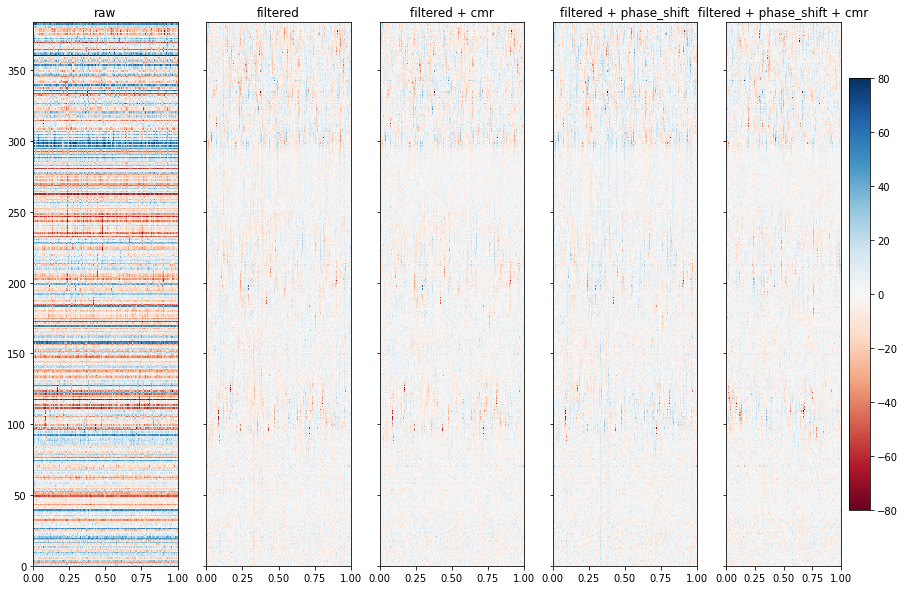

In [30]:
rec = si.read_cbin_ibl(folder1)
preprocess_steps(rec)


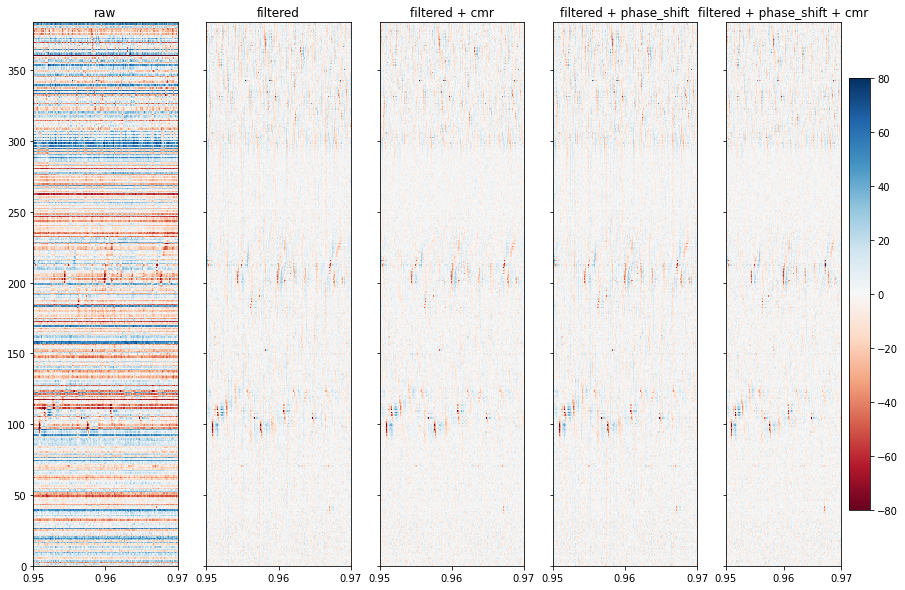

In [31]:
# zoom on a stripe
preprocess_steps(rec, time_range=(0.95, 0.97))

### dataset 2

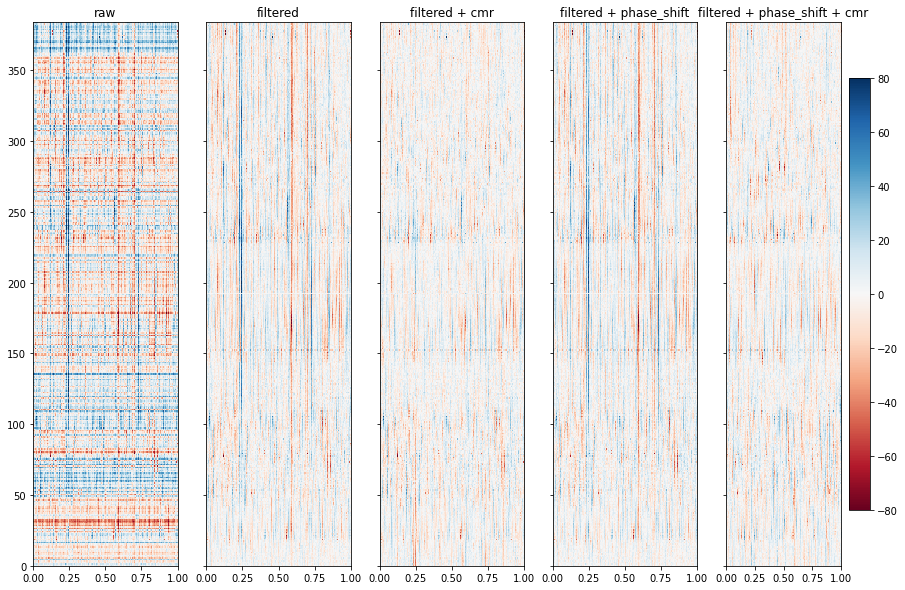

In [32]:
rec = si.read_cbin_ibl(folder2)
preprocess_steps(rec)

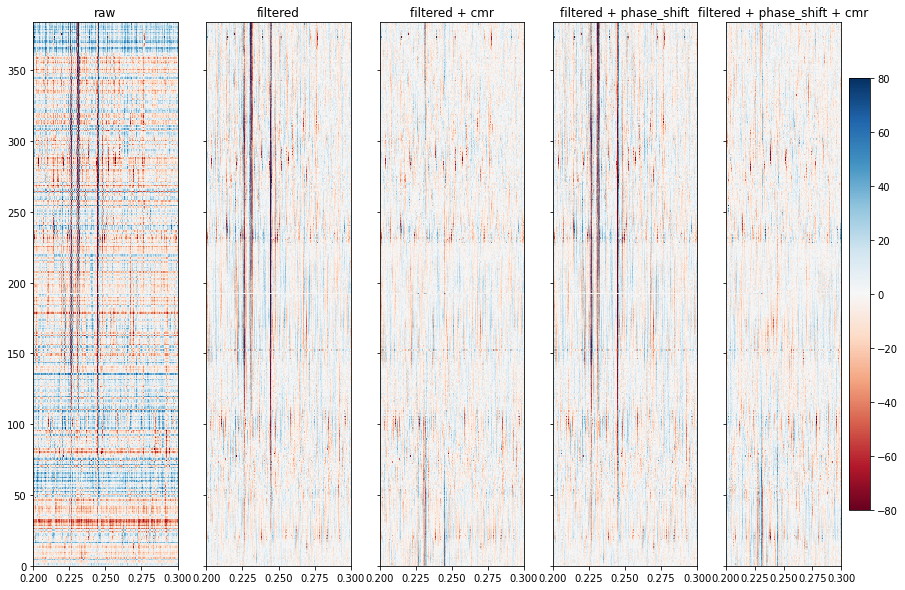

In [33]:
rec = si.read_cbin_ibl(folder2)
preprocess_steps(rec, time_range=(0.2, .3))


### dataset3

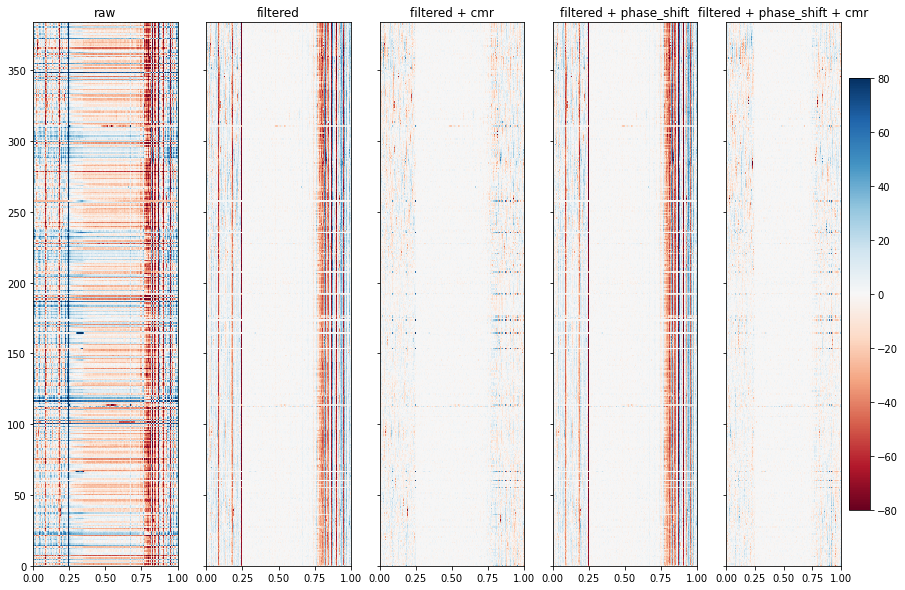

In [34]:
rec = si.read_cbin_ibl(folder3)
preprocess_steps(rec)


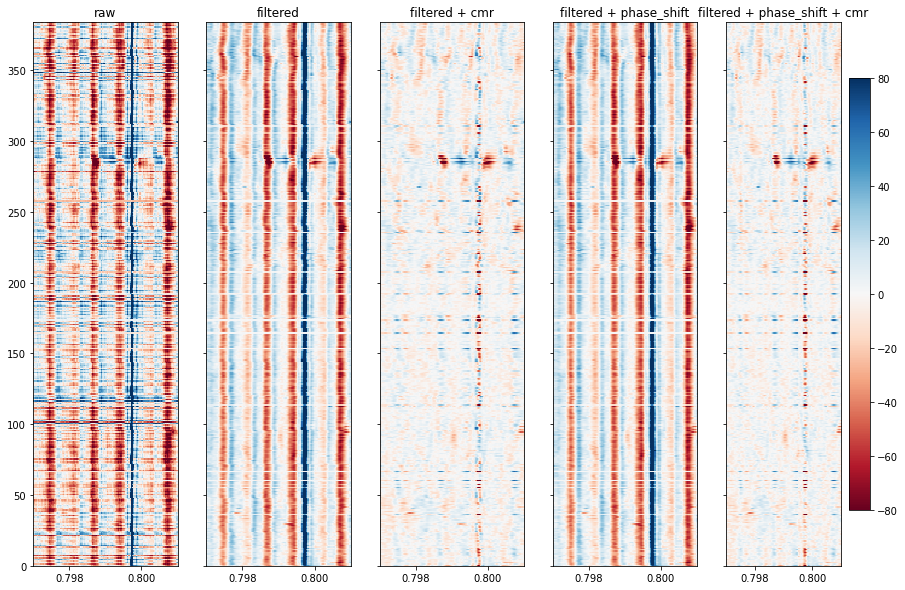

In [35]:
rec = si.read_cbin_ibl(folder3)
preprocess_steps(rec, time_range=(0.797, .801))

### dataset 4

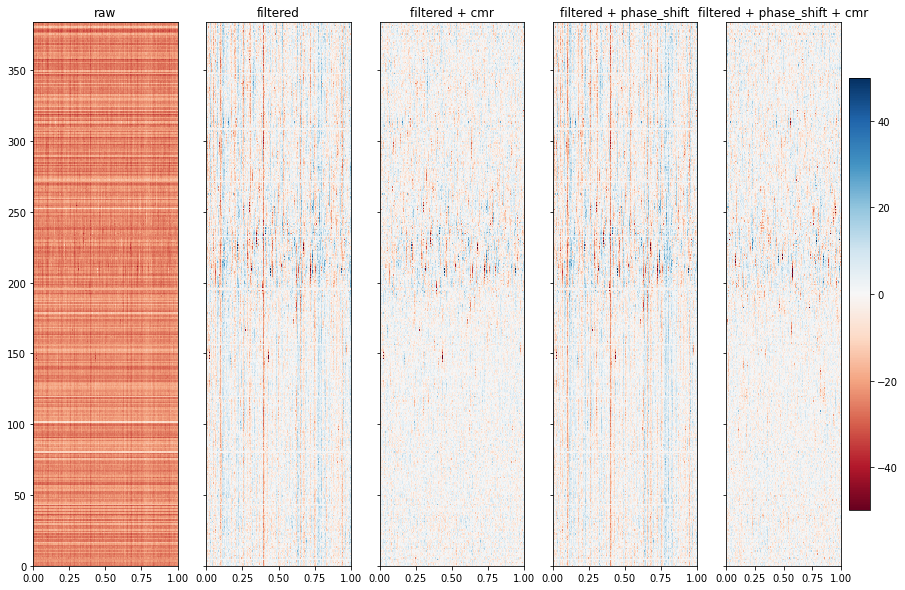

In [39]:
rec = si.read_cbin_ibl(folder4)
preprocess_steps(rec, clim=(-50, 50))

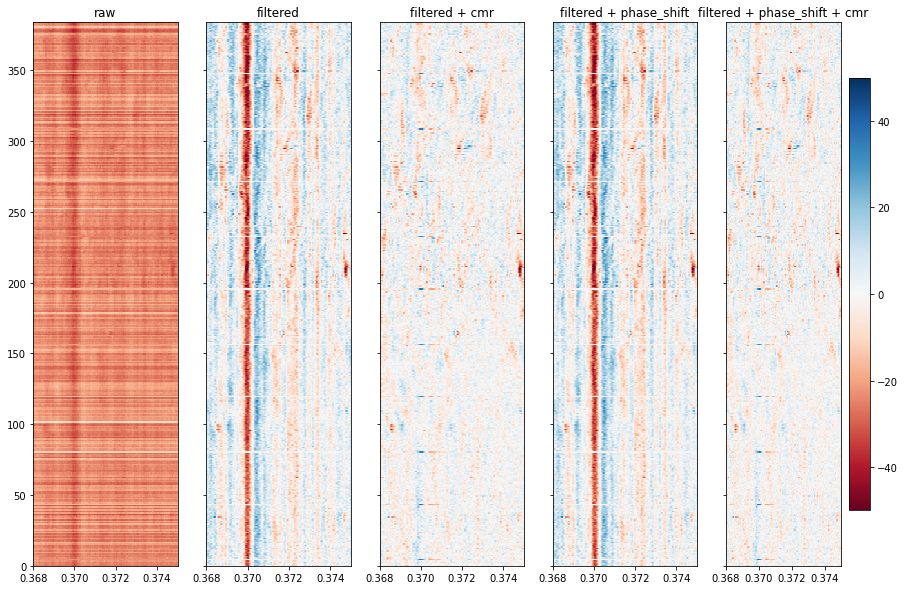

In [41]:
preprocess_steps(rec, clim=(-50, 50), time_range=(0.368, .375))

## conlusion

Here we demonstrate how to use the modular way of building a preprocessing chain directly in spikeinterface.
This is particularly usefull because:
  1. the same preprocessing can be apply for diffrent sorters
  2. The preprocessing can cached in parralel using `rec.save(...)` in binary or zarr format
  3. Every steps can be parameterized depending the in put dataset and compute ressource available.

